<a href="https://colab.research.google.com/github/Boso123/MLcourseFatiga/blob/master/reinforced_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install xgboost

# Primero determinaremos las politicas para saber la recompenza y los castigos

## Proceso de limpieza

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import figure
import seaborn as sns
from matplotlib import pyplot, dates
import numpy as np
import xgboost as xgb
import pickle
from geopy.geocoders import  Nominatim
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
trafic_data = pd.read_csv('/content/drive/My Drive/MicrosuenosData/yellow_tripdata_2019-12.csv', engine="c", infer_datetime_format=True, parse_dates=[2,3])

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
trafic_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1.0,2019-12-01 00:26:58,2019-12-01 00:41:45,1,4.2,1.0,N,142,116,2.0,14.5,3.0,0.5,0.0,0.0,0.3,18.3,2.5
1,1.0,2019-12-01 00:12:08,2019-12-01 00:12:14,1,0.0,1.0,N,145,145,2.0,2.5,0.5,0.5,0.0,0.0,0.3,3.8,0.0
2,1.0,2019-12-01 00:25:53,2019-12-01 00:26:04,1,0.0,1.0,N,145,145,2.0,2.5,0.5,0.5,0.0,0.0,0.3,3.8,0.0
3,1.0,2019-12-01 00:12:03,2019-12-01 00:33:19,2,9.4,1.0,N,138,25,1.0,28.5,0.5,0.5,10.0,0.0,0.3,39.8,0.0
4,1.0,2019-12-01 00:05:27,2019-12-01 00:16:32,2,1.6,1.0,N,161,237,2.0,9.0,3.0,0.5,0.0,0.0,0.3,12.8,2.5


In [5]:
trafic_data.describe()

,VendorID,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
count,6.845299e+06,6.896317e+06,6.845299e+06,6.896317e+06,6.896317e+06,6.845299e+06,6.896317e+06,6.896317e+06,6.896317e+06,6.896317e+06,6.896317e+06,6.896317e+06,6.896317e+06,6.896317e+06
mean,1.666457e+00,2.973421e+00,1.065756e+00,1.636525e+02,1.614892e+02,1.298993e+00,1.359027e+01,1.108518e+00,4.924147e-01,2.244620e+00,3.881238e-01,2.979857e-01,1.964165e+01,2.275278e+00
std,4.714787e-01,1.643113e+01,9.309869e-01,6.605758e+01,7.033753e+01,4.879401e-01,1.522692e+02,1.259892e+00,7.233857e-02,2.875127e+00,1.715502e+00,3.381444e-02,1.525236e+02,7.359669e-01
min,1.000000e+00,-3.726453e+04,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-1.472000e+03,-4.500000e+00,-5.000000e-01,-2.008000e+02,-4.050000e+01,-3.000000e-01,-1.472800e+03,-2.500000e+00
25%,1.000000e+00,9.600000e-01,1.000000e+00,1.250000e+02,1.120000e+02,1.000000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,1.130000e+01,2.500000e+00
50%,2.000000e+00,1.600000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,9.500000e+00,5.000000e-01,5.000000e-01,1.920000e+00,0.000000e+00,3.000000e-01,1.480000e+01,2.500000e+00
75%,2.000000e+00,3.030000e+00,1.000000e+00,2.330000e+02,2.340000e+02,2.000000e+00,1.543000e+01,2.500000e+00,5.000000e-01,3.000000e+00,0.000000e+00,3.000000e-01,2.135000e+01,2.500000e+00
max,2.000000e+00,1.913018e+04,9.900000e+01,2.650000e+02,2.650000e+02,5.000000e+00,3.984684e+05,9.006000e+01,3.300000e+00,4.044400e+02,6.126600e+02,3.000000e-01,3.984712e+05,3.000000e+00


In [0]:
trafic_data['tpep_dropoff_datetime'] = pd.to_datetime(trafic_data['tpep_dropoff_datetime'])
trafic_data['tpep_pickup_datetime'] = pd.to_datetime(trafic_data['tpep_pickup_datetime'])

delta_time = (trafic_data['tpep_dropoff_datetime']-trafic_data['tpep_pickup_datetime']).astype('timedelta64[s]')
trafic_data.insert(3, "trip_duration", delta_time)

In [7]:
trafic_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,trip_duration,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1.0,2019-12-01 00:26:58,2019-12-01 00:41:45,887.0,1,4.2,1.0,N,142,116,2.0,14.5,3.0,0.5,0.0,0.0,0.3,18.3,2.5
1,1.0,2019-12-01 00:12:08,2019-12-01 00:12:14,6.0,1,0.0,1.0,N,145,145,2.0,2.5,0.5,0.5,0.0,0.0,0.3,3.8,0.0
2,1.0,2019-12-01 00:25:53,2019-12-01 00:26:04,11.0,1,0.0,1.0,N,145,145,2.0,2.5,0.5,0.5,0.0,0.0,0.3,3.8,0.0
3,1.0,2019-12-01 00:12:03,2019-12-01 00:33:19,1276.0,2,9.4,1.0,N,138,25,1.0,28.5,0.5,0.5,10.0,0.0,0.3,39.8,0.0
4,1.0,2019-12-01 00:05:27,2019-12-01 00:16:32,665.0,2,1.6,1.0,N,161,237,2.0,9.0,3.0,0.5,0.0,0.0,0.3,12.8,2.5


In [8]:
mask = ((trafic_data.trip_duration < 60) |
        (trafic_data.trip_duration > 3600 * 2))
print('Anomalias en la duración del viaje, %: {:.2f}'.format(trafic_data[mask].shape[0] / trafic_data.shape[0] * 100))

Anomalias en la duración del viaje, %: 1.34


In [9]:
data = trafic_data[~mask]
data.trip_duration = data.trip_duration.astype(np.uint16)
print('Duración del viaje en segundos: {} to {}'.format(data.trip_duration.min(), data.trip_duration.max()))

Duración del viaje en segundos: 60 to 7200


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [10]:
data['passenger_count'] = data['passenger_count'].fillna(0)
print('Viajes vacios: {}'.format(data[data.passenger_count == 0].shape[0]))
data['passenger_count'] = data['passenger_count'].astype(np.uint16)
data = data[data.passenger_count > 0]
print('Viajes vacios: {}'.format(data[data.passenger_count == 0].shape[0]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Viajes vacios: 50790


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Viajes vacios: 0


In [11]:
data.store_and_fwd_flag = data.store_and_fwd_flag.astype('category')
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,trip_duration,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1.0,2019-12-01 00:26:58,2019-12-01 00:41:45,887,1,4.2,1.0,N,142,116,2.0,14.5,3.0,0.5,0.00,0.0,0.3,18.30,2.5
3,1.0,2019-12-01 00:12:03,2019-12-01 00:33:19,1276,2,9.4,1.0,N,138,25,1.0,28.5,0.5,0.5,10.00,0.0,0.3,39.80,0.0
4,1.0,2019-12-01 00:05:27,2019-12-01 00:16:32,665,2,1.6,1.0,N,161,237,2.0,9.0,3.0,0.5,0.00,0.0,0.3,12.80,2.5
5,1.0,2019-12-01 00:58:51,2019-12-01 01:08:37,586,2,1.0,1.0,N,161,230,2.0,6.5,3.0,0.5,0.00,0.0,0.3,10.30,2.5
9,1.0,2019-12-01 00:19:48,2019-12-01 00:24:18,270,1,0.9,1.0,N,148,4,1.0,5.5,3.0,0.5,1.85,0.0,0.3,11.15,2.5


In [0]:
data['mm_pickup'] = data.tpep_pickup_datetime.dt.month.astype(np.uint8)
data['mm_dropoff'] = data.tpep_dropoff_datetime.dt.month.astype(np.uint8)

In [0]:
data['dow_pickup'] = data.tpep_pickup_datetime.dt.weekday.astype(np.uint8)
data['dow_dropoff'] = data.tpep_dropoff_datetime.dt.weekday.astype(np.uint8)

data['hh_pickup'] = data.tpep_pickup_datetime.dt.hour.astype(np.uint8)
data['hh_dropoff'] = data.tpep_dropoff_datetime.dt.hour.astype(np.uint8)

In [14]:
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,trip_duration,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,mm_pickup,mm_dropoff,dow_pickup,dow_dropoff,hh_pickup,hh_dropoff
0,1.0,2019-12-01 00:26:58,2019-12-01 00:41:45,887,1,4.2,1.0,N,142,116,2.0,14.5,3.0,0.5,0.00,0.0,0.3,18.30,2.5,12,12,6,6,0,0
3,1.0,2019-12-01 00:12:03,2019-12-01 00:33:19,1276,2,9.4,1.0,N,138,25,1.0,28.5,0.5,0.5,10.00,0.0,0.3,39.80,0.0,12,12,6,6,0,0
4,1.0,2019-12-01 00:05:27,2019-12-01 00:16:32,665,2,1.6,1.0,N,161,237,2.0,9.0,3.0,0.5,0.00,0.0,0.3,12.80,2.5,12,12,6,6,0,0
5,1.0,2019-12-01 00:58:51,2019-12-01 01:08:37,586,2,1.0,1.0,N,161,230,2.0,6.5,3.0,0.5,0.00,0.0,0.3,10.30,2.5,12,12,6,6,0,1
9,1.0,2019-12-01 00:19:48,2019-12-01 00:24:18,270,1,0.9,1.0,N,148,4,1.0,5.5,3.0,0.5,1.85,0.0,0.3,11.15,2.5,12,12,6,6,0,0


Text(0, 0.5, 'No of Trips made')

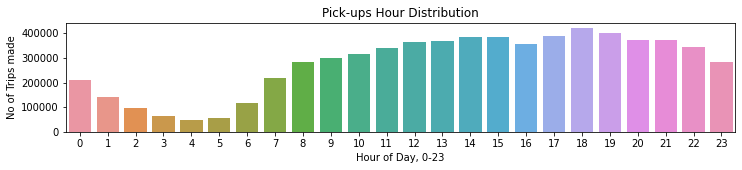

In [15]:
plt.figure(figsize=(12,2))

data_a = data.groupby('hh_pickup').aggregate('count').reset_index()
sns.barplot(x='hh_pickup', y='hh_dropoff', data=data_a)

plt.title('Pick-ups Hour Distribution')
plt.xlabel('Hour of Day, 0-23')
plt.ylabel('No of Trips made')

Text(0, 0.5, 'No of Trips made')

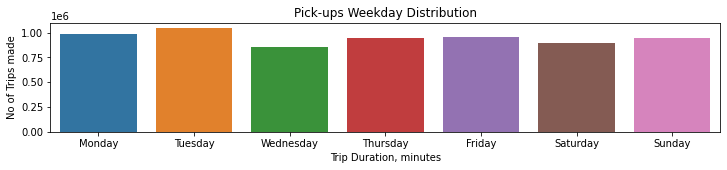

In [16]:
dow_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'] 
 
plt.figure(figsize=(12,2))

data_a = data.groupby('dow_pickup').agg('count').reset_index()
sns.barplot(x='dow_pickup', y='dow_dropoff', data=data_a)

plt.title('Pick-ups Weekday Distribution')
plt.xlabel('Trip Duration, minutes')
plt.xticks(range(0,7), dow_names, rotation='horizontal')
plt.ylabel('No of Trips made')


([<matplotlib.axis.YTick at 0x7f099b7c29e8>,
 [Text(0, 0.5, 'Sunday'),
  Text(0, 1.5, 'Saturday'),
  Text(0, 2.5, 'Friday'),
  Text(0, 3.5, 'Thursday'),
  Text(0, 4.5, 'Wednesday'),
  Text(0, 5.5, 'Tuesday'),
  Text(0, 6.5, 'Monday')])

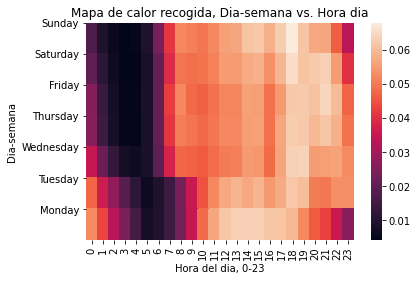

In [17]:


figure.Figure(figsize=(12,2))
sns.heatmap(data=pd.crosstab(data.dow_pickup, data.hh_pickup, values=data.VendorID, aggfunc='count', normalize='index'))
plt.title("Mapa de calor recogida, Dia-semana vs. Hora dia")
plt.ylabel('Dia-semana')
plt.xlabel('Hora del dia, 0-23')
plt.yticks(range(0,7), dow_names[::-1], rotation='horizontal')

(array([1.06496e+05, 2.56800e+05, 3.91711e+05, 4.47568e+05, 4.63671e+05,
        4.56174e+05, 4.26224e+05, 4.01997e+05, 3.63573e+05, 3.35348e+05,
        3.05209e+05, 2.73116e+05, 2.49833e+05, 2.20978e+05, 1.99391e+05,
        1.80589e+05, 1.59510e+05, 1.45245e+05, 1.27019e+05, 1.13317e+05,
        1.02363e+05, 9.02490e+04, 8.14520e+04, 7.18050e+04, 6.29520e+04,
        5.63470e+04, 4.97700e+04, 4.49990e+04, 3.93370e+04, 3.51070e+04,
        3.12890e+04, 2.79200e+04, 2.55130e+04, 2.24910e+04, 2.02790e+04,
        1.85220e+04, 1.71050e+04, 1.54260e+04, 1.41890e+04, 1.30080e+04,
        1.21700e+04, 1.12680e+04, 1.01310e+04, 9.61200e+03, 8.78600e+03,
        8.44200e+03, 7.53900e+03, 7.28600e+03, 6.61900e+03, 6.02200e+03,
        5.81500e+03, 5.35800e+03, 5.11300e+03, 4.73400e+03, 4.31900e+03,
        4.05900e+03, 3.70300e+03, 3.59000e+03, 3.20300e+03, 3.06700e+03,
        2.82400e+03, 2.62100e+03, 2.55400e+03, 2.30900e+03, 2.14800e+03,
        1.96200e+03, 1.94500e+03, 1.77700e+03, 1.58

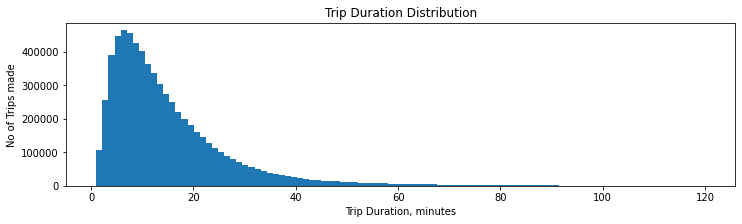

In [18]:
plt.figure(figsize=(12,3))
plt.title('Trip Duration Distribution')
plt.xlabel('Trip Duration, minutes')
plt.ylabel('No of Trips made')
plt.hist(data.trip_duration / 60, bins=100)

([<matplotlib.axis.YTick at 0x7f09865d0128>,
 [Text(0, 0.5, 'Sunday'),
  Text(0, 1.5, 'Saturday'),
  Text(0, 2.5, 'Friday'),
  Text(0, 3.5, 'Thursday'),
  Text(0, 4.5, 'Wednesday'),
  Text(0, 5.5, 'Tuesday'),
  Text(0, 6.5, 'Monday')])

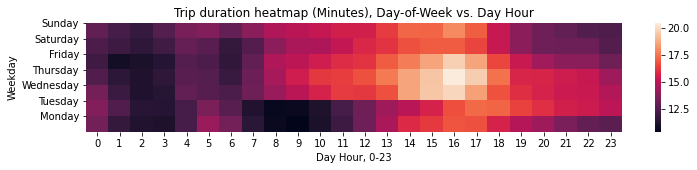

In [19]:
plt.figure(figsize=(12,2))
sns.heatmap(data=pd.crosstab(data.dow_pickup, data.hh_pickup, values=data.trip_duration/60, aggfunc='mean'))
plt.title('Trip duration heatmap (Minutes), Day-of-Week vs. Day Hour')
plt.ylabel('Weekday')
plt.xlabel('Day Hour, 0-23')
plt.yticks(range(0,7), dow_names[::-1], rotation='horizontal')

In [0]:
data.to_csv('train.csv')

In [0]:
def featureEngineer(data):
    '''
    Function to pre-process and engineer features of the train data
    '''
    # Convert character variables to numeric
    f = lambda x: 0 if x == 'N' else 1
    data["store_and_fwd_flag"] = data["store_and_fwd_flag"].apply(lambda x: f(x))

    # Convert datetime strings into datetime
    data["tpep_dropoff_datetime"] = pd.to_datetime(data["tpep_dropoff_datetime"], format='%Y-%m-%d %H:%M:%S')
    data["tpep_pickup_datetime"] = pd.to_datetime(data["tpep_pickup_datetime"], format='%Y-%m-%d %H:%M:%S')

    # Now construct other variables, like month, date, etc.
    data["pickup_month"] = data["tpep_pickup_datetime"].dt.month
    data["pickup_day"] = data["tpep_pickup_datetime"].dt.day
    data["pickup_weekday"] = data["tpep_pickup_datetime"].dt.weekday
    data["pickup_hour"] = data["tpep_pickup_datetime"].dt.hour
    data["pickup_minute"] = data["tpep_pickup_datetime"].dt.minute

    # Get latitude and longitude differences
    data["latitude_difference"] = data["dropoff_latitude"] - data["pickup_latitude"]
    data["longitude_difference"] = data["dropoff_longitude"] - data["pickup_longitude"]

    # Convert duration to minutes for easier interpretation
    data["trip_duration"] = data["trip_duration"].apply(lambda x: round(x/60))


    # Convert trip distance from longitude and latitude differences to Manhattan distance.
    data["trip_distance"] = 0.621371 * 6371 * (abs(2 * np.arctan2(np.sqrt(
        np.square(np.sin((abs(data["latitude_difference"]) * np.pi / 180) / 2))),
        np.sqrt(1 - (np.square(np.sin((abs(data["latitude_difference"]) * np.pi / 180) / 2)))))) + 
        abs(2 * np.arctan2(np.sqrt(np.square(np.sin((abs(data["longitude_difference"]) * np.pi / 180) / 2))),
                           np.sqrt(1 - (np.square(np.sin((abs(data["longitude_difference"]) * np.pi / 180) / 2)))))))

In [0]:
def rmsle(y_true, y_pred):
    '''
    Function to define evaluation metric
    >> Input: y_true -- ground truth labels, y_pred -- predicted labels
    >> Output: evaluation metric
    '''
    assert len(y_true) == len(y_pred)
    return np.square(np.log(y_pred + 1) - np.log(y_true + 1)).mean() ** 0.5

In [0]:
def XGBmodel(X, y):
    '''
    Function to train a XGBoost machine learning model on the data
    >> Input: X -- features, y -- label
    >> Output:
    '''
    # Split the train data into training, test, and valdiation sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2019)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2019)

    # XGBoost parameters
    params = {
        'booster':            'gbtree',
        'objective':          'reg:linear',
        'learning_rate':      0.05,
        'max_depth':          14,
        'subsample':          0.9,
        'colsample_bytree':   0.7,
        'colsample_bylevel':  0.7,
        'silent':             1,
        'feval':              'rmsle'
    }

    # Define train and validation sets
    dtrain = xgb.DMatrix(X_train, np.log(y_train+1))
    dval = xgb.DMatrix(X_val, np.log(y_val+1))

    # this is for tracking the error
    watchlist = [(dval, 'eval'), (dtrain, 'train')]

    # Number of training rounds
    nrounds = 1000

    # Train model
    gbm = xgb.train(params, dtrain, num_boost_round = nrounds, evals = watchlist, verbose_eval = True)

    # Test predictions
    y_pred = np.exp(gbm.predict(xgb.DMatrix(X_test))) - 1

    # Use mean absolute error to get a basic estimate of the error
    mae = (abs(y_pred - y_test)).mean()

    # Take a look at feature importance
    feature_scores = gbm.get_fscore()
    # Feature scaling
    summ = 0
    for key in feature_scores:
        summ = summ + feature_scores[key]
    for key in feature_scores:
        feature_scores[key] = feature_scores[key] / summ

    print('Mean Absolute Error:', mae)
    print('Feature Importance:', feature_scores)

    return gbm

In [32]:
taxiDB = pd.read_csv("train.csv")
featureEngineer(taxiDB)

KeyError: ignored

In [0]:
X = taxiDB.drop(["trip_duration", "id", "vendor_id", "tpep_pickup_datetime", "tpep_dropoff_datetime"], axis=1)
y = taxiDB["trip_duration"]

In [0]:
model = XGBmodel(X, y)
filename = "xgb_model.sav"
pickle.dump(model, open(filename, 'wb'))